In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import glob
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
from sklearn.metrics import r2_score
import seaborn as sns
from theano import tensor as tt
from sklearn.decomposition import NMF


pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [39]:
# Load parcellated lesion data 
lesions_collapsed_all = pd.read_csv("/Users/anna/Documents/Danilo/Stroke/Revision/Data/Lesion_data_0211.csv", index_col=0)

In [57]:
# perform NMF dimenionality reduction
n_components = 10
nmf = NMF(n_components=n_components, init='random', random_state=0)
lesions_collapsed_all_nmf = nmf.fit_transform(np.log(lesions_collapsed_all+1))

/Users/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  import sys


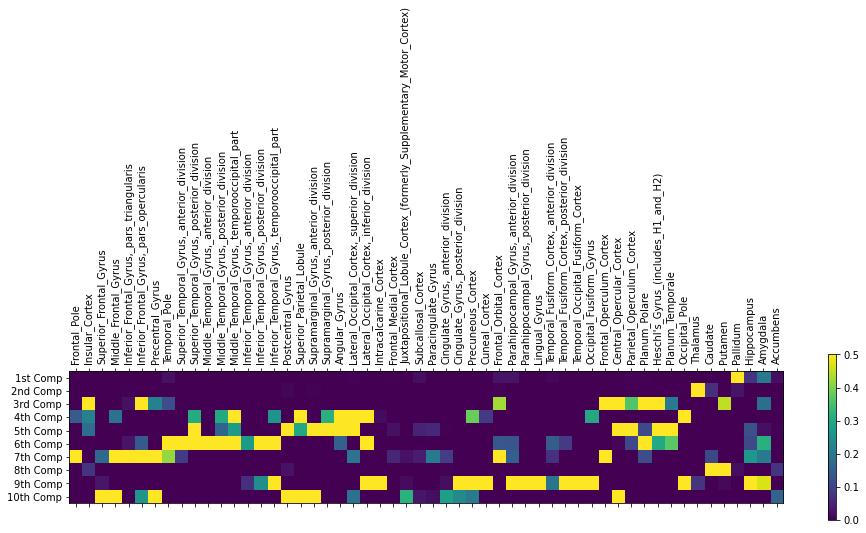

In [42]:
# Visualization of NMF embedding
plt.matshow(nmf.components_,cmap='viridis')
plt.xticks(np.arange(0,len(lesions_collapsed_all.columns)),lesions_collapsed_all.columns,fontsize=10)
plt.xticks(rotation=90)
plt.yticks([0,1,2,3,4,5,6,7,8,9],['1st Comp','2nd Comp','3rd Comp','4th Comp','5th Comp','6th Comp','7th Comp','8th Comp','9th Comp','10th Comp',],fontsize=10)
plt.colorbar()
plt.clim(0, 0.5);
plt.tight_layout()
plt.show()


In [68]:
# load clinical data
Behav_MMSE = pd.read_csv("/Users/anna/Documents/Danilo/Stroke/Revision/Data/Behavior_MMSE_0211.csv", index_col=0)

In [69]:
# Mean scaling covariates
Age_mean_scaled = Behav_MMSE["Age"] - Behav_MMSE["Age"].mean()
Age_mean_scaled_2 = np.array(Age_mean_scaled * Age_mean_scaled)

Sex_m = np.array(Behav_MMSE["Sex_1_m"])
Sex_w = np.array(Behav_MMSE["Sex_1_w"])

Age_Sex_m = Age_mean_scaled * Sex_m
Age_Sex_w = Age_mean_scaled * Sex_w

Lesion_vol_scaled = np.array(Behav_MMSE.Total_infarct_volume_scaled)

Education_mean_scaled = Behav_MMSE["Education_years"] - Behav_MMSE["Education_years"].mean() 

Education_mean_scaled = np.array(Education_mean_scaled)

interval_scaled = Behav_MMSE["interval_onset_NPO_days"] - Behav_MMSE["interval_onset_NPO_days"].mean() 

interval_scaled = np.array(interval_scaled)

IQ_mean_scaled = Behav_MMSE["IQCODE"] - Behav_MMSE["IQCODE"].mean()
IQ_mean_scaled = np.array(IQ_mean_scaled )

In [70]:
# reducing NMF representation to those with MMSE scores
lesions_collapsed_all_nmf = pd.DataFrame(lesions_collapsed_all_nmf)
lesions_collapsed_all_nmf.index = range(2160)
lesions_collapsed_all_nmf_MMSE = np.array(lesions_collapsed_all_nmf.loc[Behav_MMSE.index].copy())

In [71]:
# indicator variable for hemisphere (left/right)
hemisphere_idx = np.array(pd.read_csv("/Users/anna/Documents/Danilo/Stroke/Revision/Data/Hemisphere_MMSE_0211.csv", index_col=0)["0"])

n_hemispheres = 2

In [73]:
# Bayesian hierarchical model
with pm.Model() as hierarchical_MMSE:
    
    b_all = ["b_1", "b_2", "b_3", "b_4", "b_5", "b_6", "b_7", "b_8", "b_9", "b_10"]
    mu = pm.Normal("a", mu=0, sd=1)
    
    sigma_b_hyper = pm.HalfCauchy("sigma_b_hyper", 3.5, shape=1)
    
    sigma_b_all = pm.HalfCauchy("sigma_b_all", sigma_b_hyper, shape=2)
    
    model_lower_vars = []
    for i_component in range(n_components):
            cur_beta = pm.Normal(b_all[i_component], mu=0, sd=sigma_b_all, shape=2)
        
            mu = mu + cur_beta[hemisphere_idx] * lesions_collapsed_all_nmf_MMSE[:, i_component]
            model_lower_vars.append(cur_beta)
            
    cov1_beta = pm.Normal("cov1_ll", mu=0, sd=1, shape=1)
    mu = mu + cov1_beta * Lesion_vol_scaled
    cov2_beta = pm.Normal("cov2_age", mu=0, sd=10, shape=1)
    mu = mu + cov2_beta * Age_mean_scaled
    cov3_beta = pm.Normal("cov3_age_2", mu=0, sd=10, shape=1)
    mu = mu + cov3_beta * Age_mean_scaled_2
    cov4_beta = pm.Normal("cov4_sex_m", mu=0, sd=1, shape=1)
    mu = mu + cov4_beta * Sex_m
    cov5_beta = pm.Normal("cov5_sex_w", mu=0, sd=1, shape=1)
    mu = mu + cov5_beta * Sex_w
    cov6_beta = pm.Normal("cov6_age_sex_m", mu=0, sd=10, shape=1)
    mu = mu + cov6_beta * Age_Sex_m
    cov7_beta = pm.Normal("cov7_age_sex_w", mu=0, sd=10, shape=1)
    mu = mu + cov7_beta * Age_Sex_w
    cov8_beta = pm.Normal("cov8_ed_years", mu=0, sd=5, shape=1)
    mu = mu + cov8_beta * Education_mean_scaled
    cov9_beta = pm.Normal("cov9_IQCode", mu=0, sd=1, shape=1)
    mu = mu + cov9_beta * IQ_mean_scaled
    cov10_beta = pm.Normal("cov10_interval", mu=0, sd=10, shape=1)
    mu = mu + cov10_beta * interval_scaled
    
    # Model error
    eps = pm.HalfCauchy('eps',20)
    # Data likelihood
    Seoul_like = pm.Normal('MMSE_like', mu=mu, sd=eps, observed=np.array(Behav_MMSE.MMSE_total_zscore))

In [75]:
# sampling the posterior
with hierarchical_MMSE:
    hierarchical_MMSE_trace = pm.sample(draws=3500, n_init=1000, random_seed=1, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, cov10_interval, cov9_IQCode, cov8_ed_years, cov7_age_sex_w, cov6_age_sex_m, cov5_sex_w, cov4_sex_m, cov3_age_2, cov2_age, cov1_ll, b_10, b_9, b_8, b_7, b_6, b_5, b_4, b_3, b_2, b_1, sigma_b_all, sigma_b_hyper, a]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [1:50:41<00:00,  1.66s/it]  
The acceptance probability does not match the target. It is 0.6565842430226463, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [85]:
# saving posterior
pm.save_trace(hierarchical_MMSE_trace, "/Users/anna/Documents/Danilo/Stroke/Revision/Data/traces/MMSE_3500_0417.trace")

'/Users/anna/Documents/Danilo/Stroke/Revision/Data/traces/MMSE_3500_0417.trace'

In [48]:
# reloading posterior
with hierarchical_MMSE:
       hierarchical_MMSE = pm.load_trace("/Users/anna/Documents/Danilo/Stroke/Revision/Data/traces/MMSE_3500_0417.trace")

array([<AxesSubplot:title={'center':'x'}>], dtype=object)

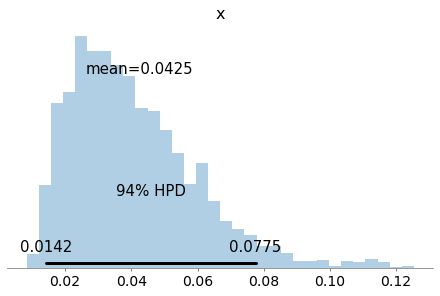

In [76]:
# Variance left hemisphere
pm.plot_posterior(hierarchical_MMSE_trace[1000:]['sigma_b_all'][:,0],round_to=3, kind='hist')

array([<AxesSubplot:title={'center':'x'}>], dtype=object)

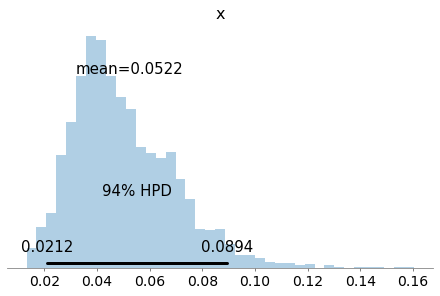

In [77]:
#Variance right hemisphere
pm.plot_posterior(hierarchical_MMSE_trace[1000:]['sigma_b_all'][:,1],round_to=3, kind='hist')

In [78]:
lesions_collapsed_all = lesions_collapsed_all.rename(columns={"Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex)": "Supplementary_Motor_Cortex", "Heschl's_Gyrus_(includes_H1_and_H2)": "Heschl's_Gyru"})
area_labels = []
for n in range(len(lesions_collapsed_all.columns)):
    area_labels.append(lesions_collapsed_all.columns[n].replace("_", " "))

/Users/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


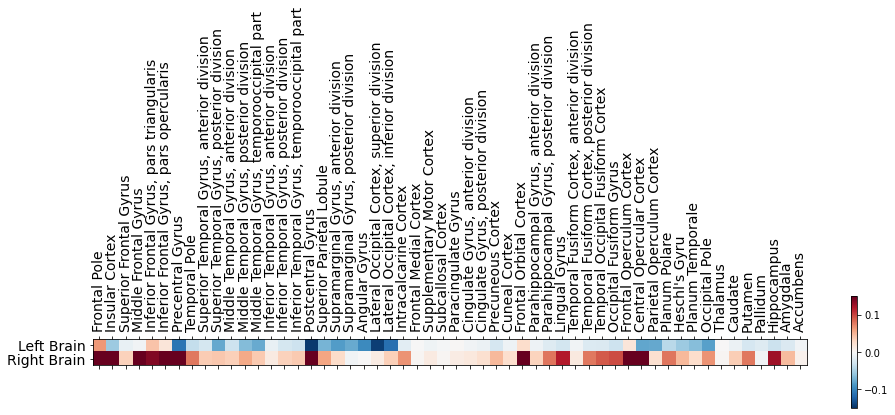

In [79]:
# Visualization of brain-region-wise relevances
# left betas
b_left = []
b_left_nmf = []
for i, i_nmf in zip(range(1, 11), range(10)):
    b_left.append(pd.DataFrame(hierarchical_MMSE_trace[1000:]["b_%i" %i])[0].mean())
b_left = np.array(b_left)

# right betas
b_right = []
b_right_nmf = []
for i, i_nmf in zip(range(1, 11), range(10)):
    b_right.append(pd.DataFrame(hierarchical_MMSE_trace[1000:]["b_%i" %i])[1].mean())
b_right = np.array(b_right)

b_left_inverse = nmf.inverse_transform(b_left)
b_right_inverse = nmf.inverse_transform(b_right)

b_inverse = pd.DataFrame(b_left_inverse)
b_inverse = b_inverse.rename(columns={0: "left"})
b_inverse["right"] = pd.DataFrame(b_right_inverse)

b_left_nmf = pd.DataFrame(b_left_nmf)
b_right_nmf = pd.DataFrame(b_right_nmf)

plt.matshow(np.array(b_inverse.transpose()),cmap='RdBu_r')
plt.xticks(np.arange(0,len(lesions_collapsed_all.columns)),area_labels,fontsize=14)
plt.xticks(rotation=90)
plt.yticks([0,1],['Left Brain','Right Brain'],fontsize=14)
plt.colorbar()
plt.clim(-0.15, 0.15);
plt.tight_layout()
plt.show()

/Users/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/anna/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:04<00:00, 494.84it/s]


PPC in sample R^2: 0.557483


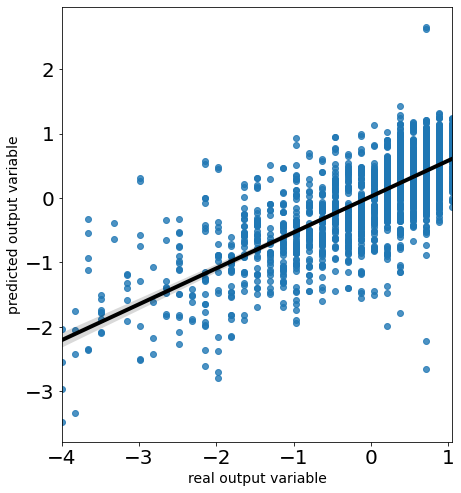

In [81]:
# R2-Score
Y_ppc_insample = pm.sample_ppc(hierarchical_MMSE_trace[1000:], 2000, hierarchical_MMSE)['MMSE_like']
y_pred_insample = Y_ppc_insample.mean(axis=0)
ppc_insample = r2_score(Behav_MMSE.MMSE_total_zscore, y_pred_insample)
out_str = 'PPC in sample R^2: %2.6f' % (ppc_insample)
print(out_str)

plt.figure(figsize=(7, 8))
sns.regplot(x=Behav_MMSE.MMSE_total_zscore, y=y_pred_insample, fit_reg=True, ci=95,
    line_kws={'color':'black', 'linewidth':4})
plt.xlabel('real output variable',fontsize=14)
plt.ylabel('predicted output variable',fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

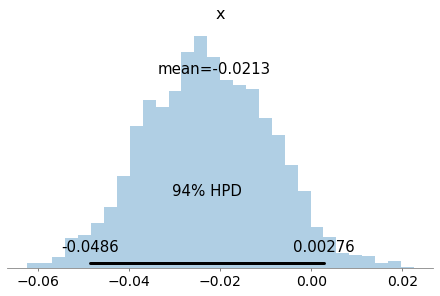

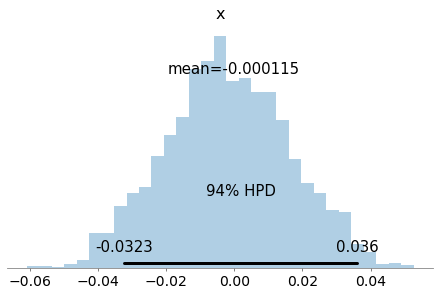

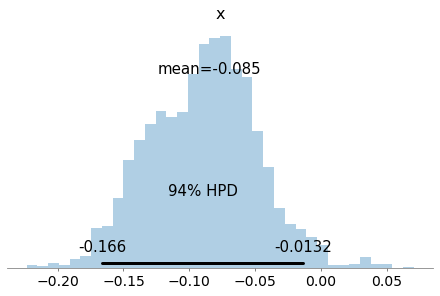

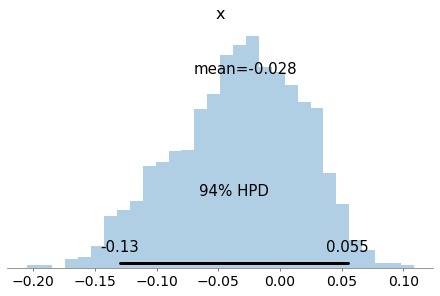

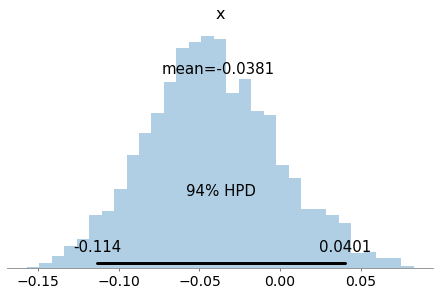

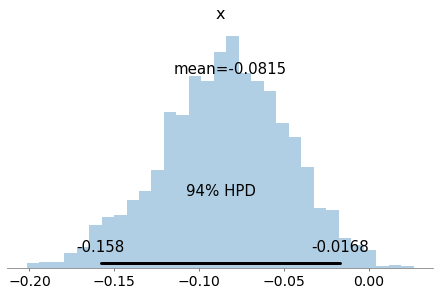

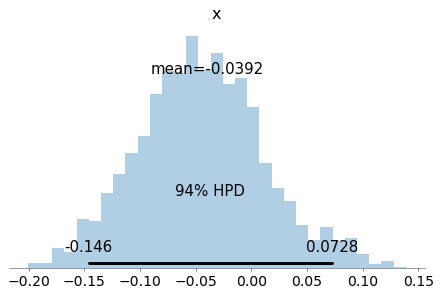

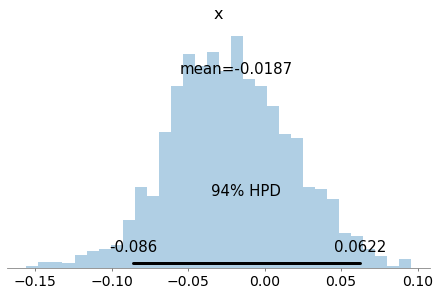

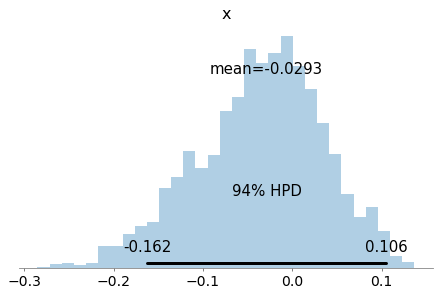

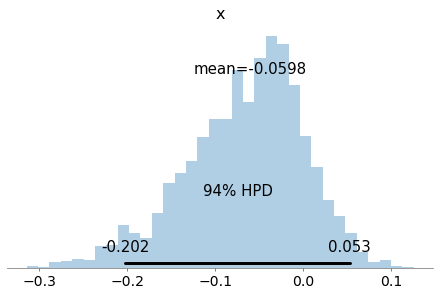

In [82]:
# Difference distributions: Left - Right
for i in range(1, 11):
    fig = pm.plot_posterior((hierarchical_MMSE_trace[1000:]['b_%i' % i][:,0] - hierarchical_MMSE_trace[1000:]['b_%i' % i][:,1]),round_to=3, kind='hist')
    #fig.set_xlim(-0.2, 0.2)

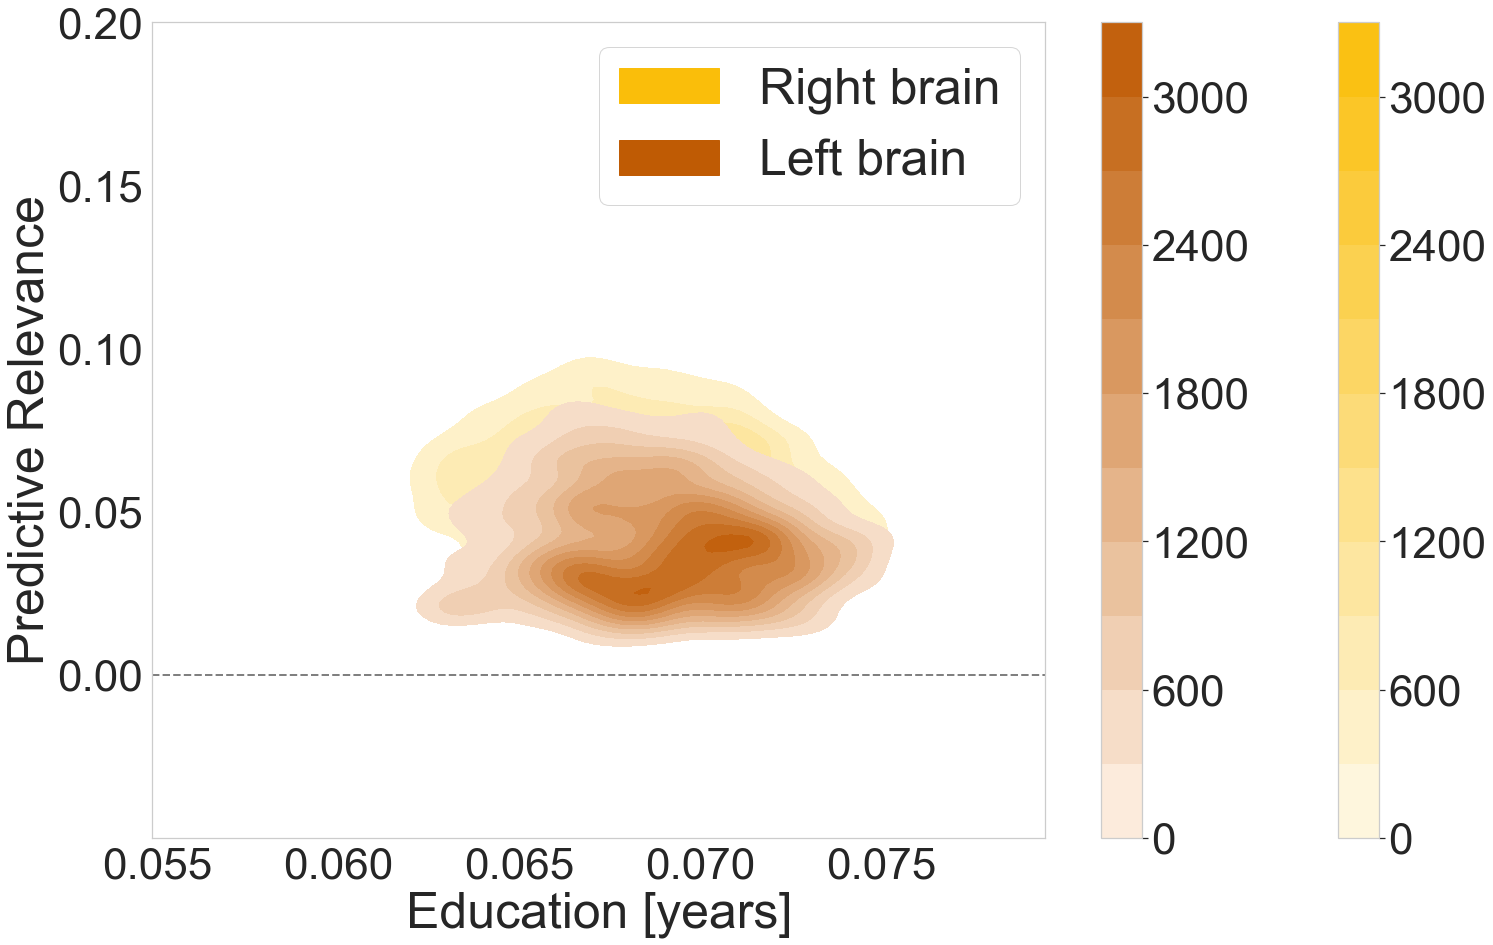

In [83]:
# posterior density plots
for i in [1]:
    plt.figure(figsize=(25,15))
    NMF_L = hierarchical_MMSE_trace[1000:]['sigma_b_all'][:,0] 
    NMF_R = hierarchical_MMSE_trace[1000:]['sigma_b_all'][:,1]

    sns.set(style="whitegrid",font_scale=4)

    sns.kdeplot(np.array(hierarchical_MMSE_trace[1000:]['cov8_ed_years'])[:,0], NMF_R, shade=True, color="#fabe0a", label="Right brain", shade_lowest=False, cbar=True)
    
    sns.kdeplot(np.array(hierarchical_MMSE_trace[1000:]['cov8_ed_years'])[:,0], NMF_L, shade=True, color="#BF5B04", label="Left brain", shade_lowest=False, cbar=True)
    plt.axhline(y=0.0, color="grey",lw=2,ls="--")
    plt.grid(False)
    plt.yticks(np.arange(-0.0, 0.25, step=0.05)) 
    plt.ylim(-0.05,0.2)
    plt.xlabel('Education [years]',fontsize=50)
    plt.ylabel('Predictive Relevance',fontsize=50)
    plt.legend(fontsize=50, loc="upper right")
    plt.show()
    

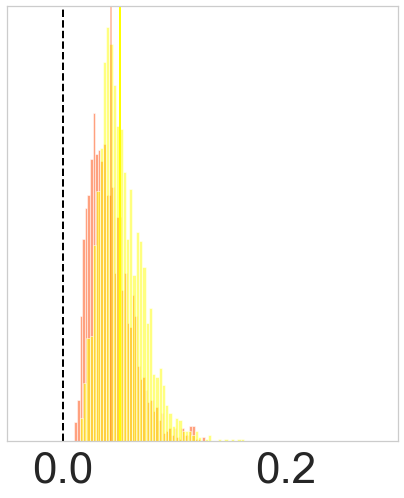

In [84]:
# Variance left & right hemisphere
sns.set(style="whitegrid",font_scale=4)
plt.figure(figsize=(7, 8))
#fig = plt.hist((hierarchical_all_parcels_education_log_trace_3_b35_intercept[1000:]['sigma_b_all'][:,1]), bins=50, color="yellow")
fig = plt.hist((hierarchical_MMSE_trace[1000:]['sigma_b_all'][:,0]), bins=50, color="orangered", alpha=0.5)
fig = plt.hist((hierarchical_MMSE_trace[1000:]['sigma_b_all'][:,1]), bins=50, color="yellow", alpha=0.5)

plt.grid(b=None)
plt.axvline(x=0.0, color="black",lw=2,ls="--")
plt.axvline(x=0.0513, color="yellow",lw=2,ls="-")
plt.axvline(x=0.0432, color="orangered",lw=2,ls="-", alpha=0.3)
plt.xlim((-0.05, 0.3))
plt.yticks([])
plt.show()